In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Definisanje transformacija
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Putanje do dataseta
original_train_path = '../datasets/images/original/train'
original_test_path = '../datasets/images/original/test'
synthetic_train_path = '../datasets/images/generated/train'

# Učitavanje originalnih podataka
train_dataset = ImageFolder(root=original_train_path, transform=transform)
test_dataset = ImageFolder(root=original_test_path, transform=transform)

# Učitavanje sintetičkih podataka
synthetic_train_dataset = ImageFolder(root=synthetic_train_path, transform=transform)

print(f"Broj slika u originalnom trening setu: {len(train_dataset)}")
print(f"Broj slika u originalnom test setu: {len(test_dataset)}")
print(f"Broj slika u sintetičkom trening setu: {len(synthetic_train_dataset)}")

Broj slika u originalnom trening setu: 4352
Broj slika u originalnom test setu: 1088
Broj slika u sintetičkom trening setu: 1000


In [2]:
class CombinedDataset(Dataset):
    def __init__(self, original_dataset, synthetic_dataset, synthetic_percentage, transform=None):
        self.original_dataset = original_dataset
        self.synthetic_dataset = synthetic_dataset
        self.synthetic_percentage = synthetic_percentage
        self.transform = transform
        
        self.data = self.combine_datasets()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_path, label = self.data[index]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def combine_datasets(self):
        combined_data = self.original_dataset.samples.copy()
        
        if self.synthetic_percentage > 0:
            num_synthetic_to_add = int(len(self.synthetic_dataset) * self.synthetic_percentage)
            synthetic_samples = self.synthetic_dataset.samples[:num_synthetic_to_add]
            combined_data.extend(synthetic_samples)
        
        return combined_data

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    train_metrics, train_y_true, train_y_pred, train_y_score = evaluate(model, train_loader, device)
    test_metrics, test_y_true, test_y_pred, test_y_score = evaluate(model, test_loader, device)
    
    return train_metrics, test_metrics, train_y_true, train_y_pred, train_y_score, test_y_true, test_y_pred, test_y_score

def evaluate(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_scores.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    }, all_labels, all_preds, all_scores



Evaluacija sa 0.0% sintetičkih podataka u trening setu:
Broj slika u kombinovanom trening setu: 4352
Epoch [1/10], Loss: 0.5383
Epoch [2/10], Loss: 0.5597
Epoch [3/10], Loss: 0.9771
Epoch [4/10], Loss: 0.1051
Epoch [5/10], Loss: 0.0746
Epoch [6/10], Loss: 0.0076
Epoch [7/10], Loss: 0.0124
Epoch [8/10], Loss: 0.0037
Epoch [9/10], Loss: 0.0501
Epoch [10/10], Loss: 0.0109
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.997472  0.997472   0.997488  0.997474
1      Test  0.636949  0.636949   0.733400  0.625461


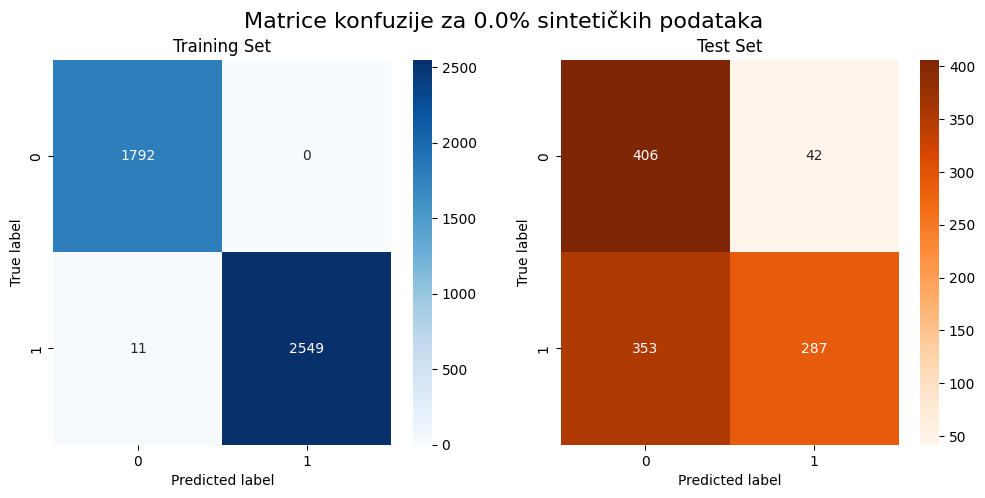

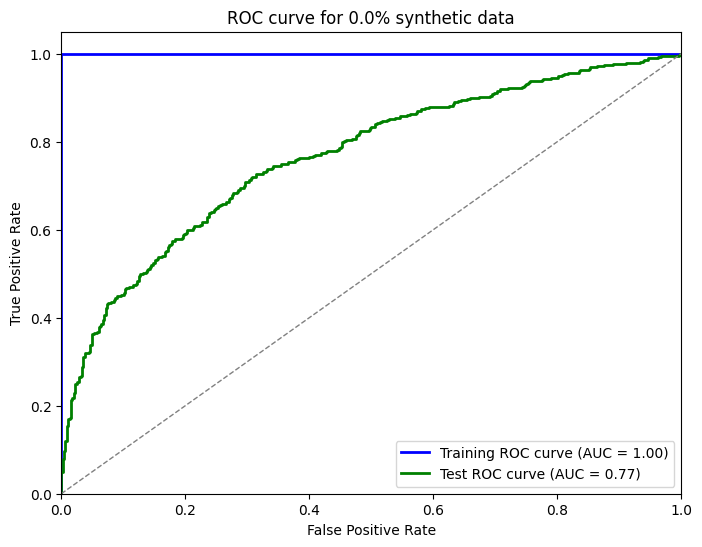


Evaluacija sa 50.0% sintetičkih podataka u trening setu:
Broj slika u kombinovanom trening setu: 4852
Epoch [1/10], Loss: 0.5431
Epoch [2/10], Loss: 0.3538
Epoch [3/10], Loss: 0.1730
Epoch [4/10], Loss: 0.1378
Epoch [5/10], Loss: 0.0329
Epoch [6/10], Loss: 0.0933
Epoch [7/10], Loss: 0.0150
Epoch [8/10], Loss: 0.0730
Epoch [9/10], Loss: 0.0330
Epoch [10/10], Loss: 0.1137
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.997115  0.997115   0.997115  0.997115
1      Test  0.727941  0.727941   0.740796  0.730047


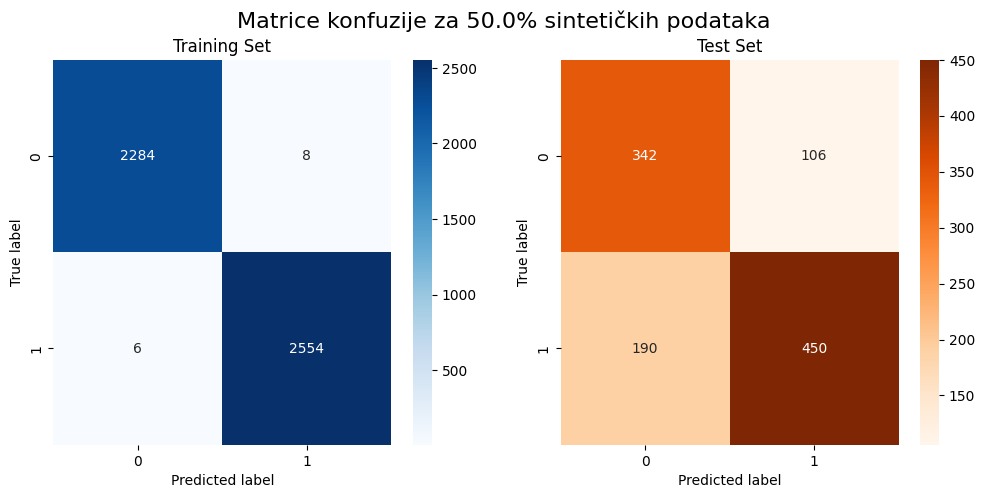

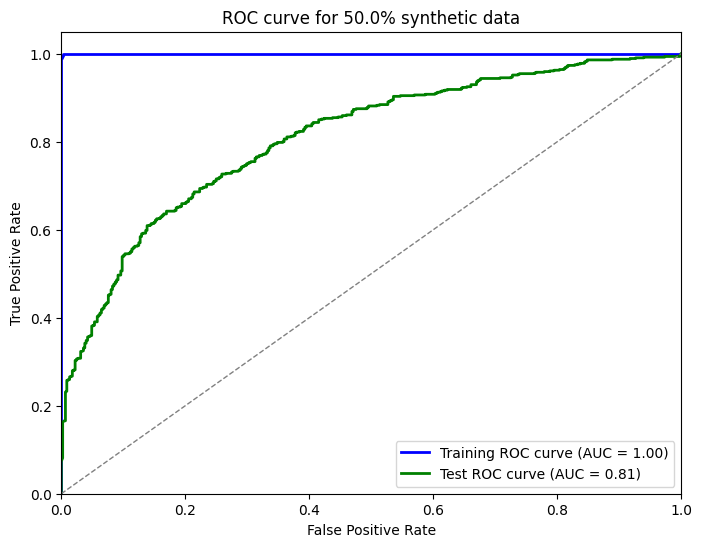


Evaluacija sa 100.0% sintetičkih podataka u trening setu:
Broj slika u kombinovanom trening setu: 5352
Epoch [1/10], Loss: 0.4410
Epoch [2/10], Loss: 0.7383
Epoch [3/10], Loss: 0.2162
Epoch [4/10], Loss: 0.1498
Epoch [5/10], Loss: 0.0913
Epoch [6/10], Loss: 0.0506
Epoch [7/10], Loss: 0.0176
Epoch [8/10], Loss: 0.0295
Epoch [9/10], Loss: 0.0019
Epoch [10/10], Loss: 0.0028
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  1.000000  1.000000   1.000000   1.00000
1      Test  0.679228  0.679228   0.698739   0.68166


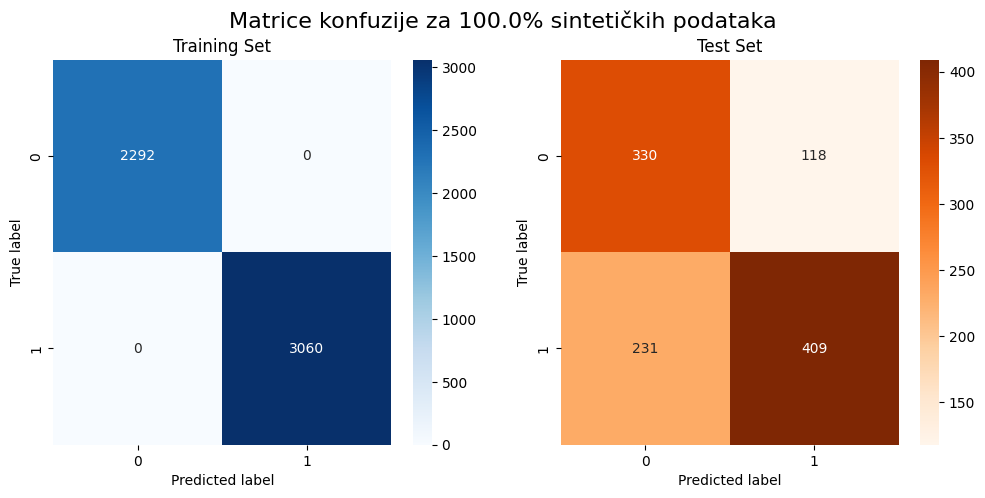

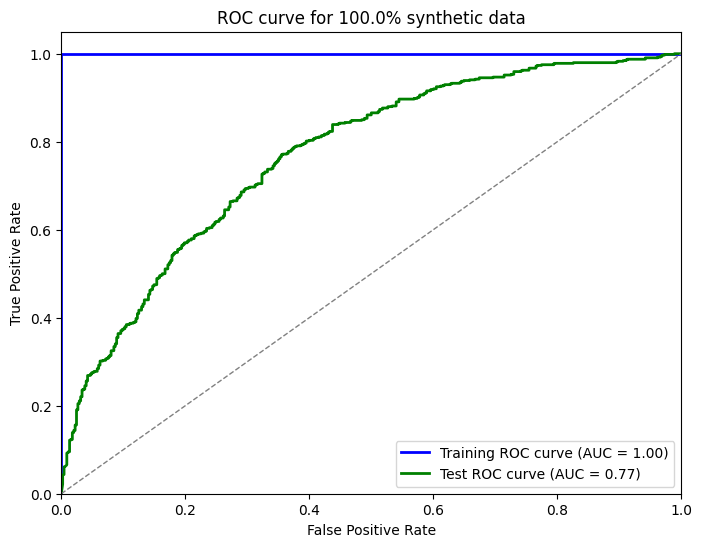

In [5]:
# Kreiranje DataLoader-a za test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluacija za različite procente sintetičkih podataka
synthetic_percentages = [0.0, 0.5, 1.0]  # 0%, 50%, 100%

for idx, percentage in enumerate(synthetic_percentages):
    print(f"\nEvaluacija sa {percentage*100}% sintetičkih podataka u trening setu:")
    
    combined_train_dataset = CombinedDataset(train_dataset, synthetic_train_dataset, percentage, transform)
    train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
    
    print(f"Broj slika u kombinovanom trening setu: {len(combined_train_dataset)}")
    
    model = CNNModel()
    train_metrics, test_metrics, train_y_true, train_y_pred, train_y_score, test_y_true, test_y_pred, test_y_score = train_and_evaluate(model, train_loader, test_loader)
    
    # Kreiranje DataFrame-a sa rezultatima
    results = pd.DataFrame({
        'Dataset': ['Training', 'Test'],
        'Accuracy': [train_metrics['Accuracy'], test_metrics['Accuracy']],
        'Recall': [train_metrics['Recall'], test_metrics['Recall']],
        'Precision': [train_metrics['Precision'], test_metrics['Precision']],
        'F1-score': [train_metrics['F1-score'], test_metrics['F1-score']]
    })
    
    # Ispis rezultata
    print(results)
    
    # Prikaz matrica konfuzije
    cm_train = confusion_matrix(train_y_true, train_y_pred)
    cm_test = confusion_matrix(test_y_true, test_y_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Matrice konfuzije za {percentage*100}% sintetičkih podataka', fontsize=16)
    
    # Prikaz matrice konfuzije za trening set
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Training Set')
    axes[0].set_ylabel('True label')
    axes[0].set_xlabel('Predicted label')

    # Prikaz matrice konfuzije za test set
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
    axes[1].set_title('Test Set')
    axes[1].set_ylabel('True label')
    axes[1].set_xlabel('Predicted label')
    
    plt.show()
    
    # Prikaz ROC krive
    fpr_train, tpr_train, _ = roc_curve(train_y_true, train_y_score)
    fpr_test, tpr_test, _ = roc_curve(test_y_true, test_y_score)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC curve (AUC = {auc(fpr_train, tpr_train):.2f})')
    plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {auc(fpr_test, tpr_test):.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {percentage*100}% synthetic data')


    plt.legend(loc='lower right')
    plt.show()
    